In [34]:
# basic splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

### Recursive Text Chunking

### Load the articles 

In [2]:
df_articles = pd.read_csv('articles.csv')

In [8]:
ex_ = df_articles['article'].iloc[5]

print(len(ex_.split()))
print(ex_)



90
Les plans, les programmes et les documents d'orientation politique élaborés par la Région, des pouvoirs publics régionaux ou par des pouvoirs publics locaux en matière de logement, de mobilité ou de recherche et d'innovation, ainsi que les plans et programmes visés au CoBAT, s'inscrivent en conformité avec les objectifs poursuivis par le plan régional Air-Climat-énergie. Il en va de même des contrats de gestion et autres conventions conclus par la Région avec les pouvoirs publics régionaux. Le plan régional Air-Climat-Energie s'inscrit dans les objectifs du Plan Régional de Développement Durable.


---------

### Create Text Splitter: Semantic-chunker

In [4]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings



In [11]:
model_name = "BAAI/bge-m3"
# model_name = "Lajavaness/bilingual-embedding-large"
encode_kwargs = {'normalize_embeddings': False,
                 'batch_size': 8,}
model_kwargs = {
    'device': 'cuda',
    # 'trust_remote_code': True  
}

hf_embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs,
        show_progress = False,

    )

In [14]:
text_splitter = SemanticChunker(embeddings=hf_embeddings,
                                breakpoint_threshold_type = 'percentile',
                                # breakpoint_threshold_amount=95,  # cosine distance
                                 #["\n\n", ".", ";", ".§"]
                                sentence_split_regex =  r'\n\n\s+|\.\s+|;\s+|\.§\s+' # S+ == space 
                                )

In [9]:

docs = text_splitter.create_documents([ex_])

print(len(docs))
print(docs[0].page_content)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2
Les plans, les programmes et les documents d'orientation politique élaborés par la Région, des pouvoirs publics régionaux ou par des pouvoirs publics locaux en matière de logement, de mobilité ou de recherche et d'innovation, ainsi que les plans et programmes visés au CoBAT, s'inscrivent en conformité avec les objectifs poursuivis par le plan régional Air-Climat-énergie Il en va de même des contrats de gestion et autres conventions conclus par la Région avec les pouvoirs publics régionaux


In [10]:
print(docs[1].page_content)

Le plan régional Air-Climat-Energie s'inscrit dans les objectifs du Plan Régional de Développement Durable.


-----------

In [12]:
from tqdm.autonotebook import tqdm

In [15]:
# List to store the chunked articles and metadata
chunked_data = []

# Iterate over each article in the DataFrame
for _, row in tqdm(df_articles.iterrows(), total=len(df_articles), desc="Chunking articles"):
    article_text = row['article']
    
    # Perform chunking with SemanticChunker
    docs = text_splitter.create_documents([article_text])
    
    # Append each chunk with its metadata to the list
    for doc in docs:
        chunked_data.append({
            'article_id': row['id'],
            'code': row['code'],
            'reference': row['reference'],
            'chunk': doc.page_content  # Access the chunk content
        })

# Create a new DataFrame with the chunked data and metadata
df_chunked_articles = pd.DataFrame(chunked_data)

Chunking articles:   0%|          | 0/22633 [00:00<?, ?it/s]

In [16]:
df_chunked_articles.to_csv('chunked_articles.csv', index=True)

### Load Chunked articles

In [26]:
df_chunked_articles = pd.read_csv('chunked_articles.csv')
df_chunked_articles.head()

,Unnamed: 0,article_id,code,reference,chunk
0,0,1,"Code Bruxellois de l'Air, du Climat et de la M...","Art. 1.1.1, Code Bruxellois de l'Air, du Clima...",Le présent Code règle une matière visée à l'ar...
1,1,2,"Code Bruxellois de l'Air, du Climat et de la M...","Art. 1.1.2, Code Bruxellois de l'Air, du Clima...",Le présent Code transpose en Région de Bruxell...
2,2,3,"Code Bruxellois de l'Air, du Climat et de la M...","Art. 1.2.1, Code Bruxellois de l'Air, du Clima...",Le présent Code poursuit les objectifs suivant...
3,3,4,"Code Bruxellois de l'Air, du Climat et de la M...","Art. 1.3.1, Code Bruxellois de l'Air, du Clima...","Au sens du présent Code, il faut entendre par ..."
4,4,5,"Code Bruxellois de l'Air, du Climat et de la M...","Art. 1.4.1, Code Bruxellois de l'Air, du Clima...","Le plan régional Air-Climat-énergie, ci-après ..."


In [8]:
df_chunked_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29927 entries, 0 to 29926
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  29927 non-null  int64 
 1   article_id  29927 non-null  int64 
 2   code        29927 non-null  object
 3   reference   29927 non-null  object
 4   chunk       29925 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [28]:
# Convert all entries in the 'chunk' column to strings
df_chunked_articles['chunk'] = df_chunked_articles['chunk'].astype(str)

# Now calculate the length of each chunk
chunk_len = [len(chunk.split()) for chunk in df_chunked_articles['chunk']]



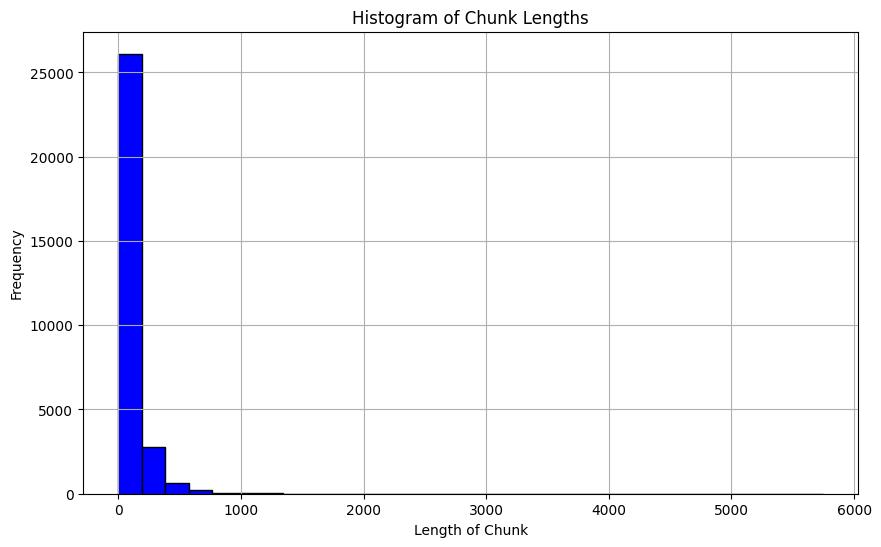

In [17]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(chunk_len, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Chunk Lengths')
plt.xlabel('Length of Chunk')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
sorted_chunk_len = sorted(chunk_len)
max = sorted_chunk_len[-4000:]
print(max)

[187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193,

In [27]:
# number of chunks that length is greater than 100
chunk_500 = sum(i > 500 for i in chunk_len)
print(chunk_500)


580


In [14]:
# count the number of articles_ids that is count greater than 2
ids_articles = df_chunked_articles['article_id'].value_counts()
ids_articles = ids_articles[ids_articles > 2]


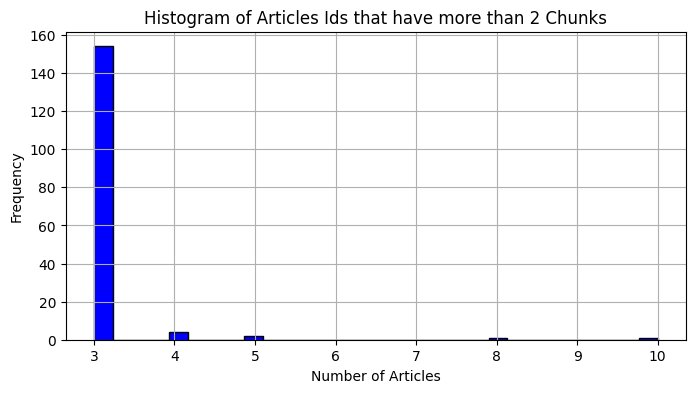

In [13]:
# display on graph the number of articles_ids that is count greater than 2

plt.figure(figsize=(8, 4))
plt.hist(ids_articles, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Articles Ids that have more than 2 Chunks')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


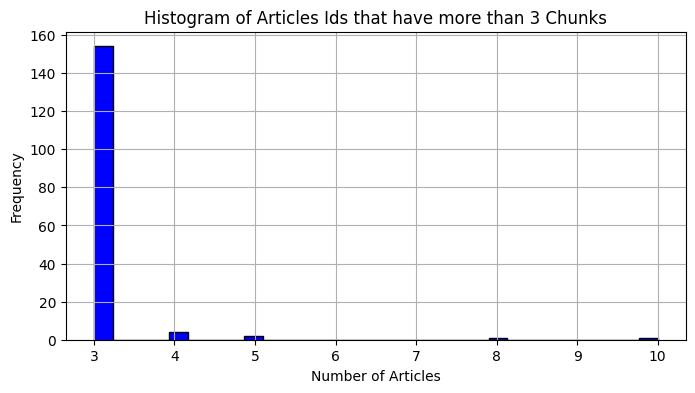

In [16]:
# display on graph the number of articles_ids that is count greater than 2

plt.figure(figsize=(8, 4))
plt.hist(ids_articles, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Articles Ids that have more than 3 Chunks')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
# number of chunks that length is less than 100
chunk_100 = sum(i < 10 for i in chunk_len)
print(chunk_100)

604


In [22]:
# min number of chunks that length is less than 100
chunk_10 = [i for i in chunk_len if i < 10]
print(chunk_100)

[1, 9, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 8, 1, 1, 1, 2, 1, 1, 1, 1, 5, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 6, 1, 6, 5, 2, 3, 9, 3, 8, 1, 9, 2, 3, 1, 1, 9, 1, 9, 2, 6, 2, 7, 8, 2, 7, 7, 7, 1, 2, 9, 7, 8, 1, 1, 9, 6, 1, 1, 1, 1, 9, 8, 7, 8, 7, 2, 6, 9, 1, 1, 5, 8, 8, 7, 8, 5, 8, 5, 9, 9, 6, 7, 6, 9, 9, 9, 8, 7, 1, 9, 9, 6, 1, 8, 7, 6, 6, 7, 1, 1, 2, 3, 6, 6, 7, 2, 8, 9, 1, 9, 3, 4, 2, 2, 2, 2, 7, 2, 1, 9, 2, 8, 1, 8, 8, 2, 1, 1, 1, 3, 3, 2, 6, 2, 2, 1, 1, 1, 5, 9, 8, 8, 9, 2, 7, 1, 8, 9, 8, 9, 8, 9, 8, 5, 7, 8, 4, 8, 6, 1, 1, 6, 2, 2, 2, 2, 8, 6, 8, 9, 8, 4, 8, 9, 9, 2, 2, 2, 9, 5, 8, 8, 8, 2, 2, 1, 8, 9, 7, 3, 8, 7, 5, 1, 3, 3, 1, 9, 9, 7, 7, 7, 4, 9, 9, 8, 3, 2, 1, 5, 8, 2, 2, 1, 7, 9, 2, 4, 7, 1, 2, 9, 1, 1, 2, 8, 9, 1, 2, 2, 9, 1, 1, 1, 1, 1, 8, 9, 9, 8, 1, 8, 8, 7, 7, 1, 1, 8, 8, 8, 1, 2, 7, 9, 1, 4, 1, 6, 9, 8, 2, 9, 2, 8, 9, 2, 2, 8, 4, 5, 2, 2, 1, 9, 7, 9, 9, 3, 3, 3, 9, 4, 4, 5, 9, 9, 2, 9, 9, 2, 2, 6, 2, 7, 9, 1, 1, 2, 5, 

In [32]:
# function that return the length of the chunk
def len_chunk(chunk):
    return len(chunk.split())
# now column len chunk
df_chunked_articles['len_chunk'] = df_chunked_articles['chunk'].apply(len_chunk)

# sorted the df by len_chunk
df_chunked_articles = df_chunked_articles.sort_values(by='len_chunk', ascending=True)
df_chunked_articles.head(100)


,Unnamed: 0,article_id,code,reference,chunk,len_chunk
6704,6704,5141,Code Judiciaire,"Art. 1039, Code Judiciaire (Livre II, Titre ré...",1,1
655,655,433,Code Bruxellois de l'Aménagement du Territoire,"Art. 213, Code Bruxellois de l'Aménagement du ...",(457),1
683,683,451,Code Bruxellois de l'Aménagement du Territoire,"Art. 230, Code Bruxellois de l'Aménagement du ...",(507),1
18055,18055,13977,Code de Droit Economique,"Art. III.26, Code de Droit Economique (Livre I...",3,1
11973,11973,9442,Code Réglementaire Wallon de l'Action sociale ...,"Art. 1590, Code Réglementaire Wallon de l'Acti...",B.Sanctions,1


### Second Chunking: Recursive chunking 

In [35]:
splitter = RecursiveCharacterTextSplitter(
        chunk_size=250,
        chunk_overlap=10,
        length_function= len_chunk,
        separators=["\n\n", ".", ";", ".§"],
        is_separator_regex=False
)

In [36]:
splitter.create_documents([df_chunked_articles['chunk'][0]])


[Document(metadata={}, page_content="Le présent Code règle une matière visée à l'article 39 de la Constitution.")]

In [49]:
# List to store the chunked articles and metadata
Recursivechunked_data = []

# Iterate over each article in the DataFrame
for _, row in tqdm(df_chunked_articles.iterrows(), total=len(df_chunked_articles), desc=" RECURSIVE Chunking articles"):
    chunk_text = row['chunk']
    len_chunk = row['len_chunk']

    if len_chunk > 250:
        # Perform chunking with splitter recursive
        docs = splitter.create_documents([chunk_text])
        
        # Append each chunk with its metadata to the list
        for doc in docs:
            Recursivechunked_data.append({
                'article_id': row['article_id'],
                'code': row['code'],
                'reference': row['reference'],
                'chunk': doc.page_content  # Access the chunk content
            })
    else:
        Recursivechunked_data.append({
            'article_id': row['article_id'],
            'code': row['code'],
            'reference': row['reference'],
            'chunk': chunk_text  # Access the chunk content
        })

# Create a new DataFrame with the chunked data and metadata
df_Recursivechunked_articles = pd.DataFrame(Recursivechunked_data)

 RECURSIVE Chunking articles:   0%|          | 0/29927 [00:00<?, ?it/s]

In [38]:
df_Recursivechunked_articles.to_csv('Recursivechunked_articles.csv', index=True)

In [40]:
df_Recursivechunked_articles.head(2)

,article_id,code,reference,chunk
0,5141,Code Judiciaire,"Art. 1039, Code Judiciaire (Livre II, Titre ré...",1
1,433,Code Bruxellois de l'Aménagement du Territoire,"Art. 213, Code Bruxellois de l'Aménagement du ...",(457)


In [51]:
# length of the chunk
def len_chunk(chunk):
    return len(chunk.split())

df_Recursivechunked_articles['chunk'] = df_Recursivechunked_articles['chunk'].astype(str)
df_Recursivechunked_articles['len_chunk'] = df_Recursivechunked_articles['chunk'].apply(len_chunk)

In [46]:
df_Recursivechunked_articles = df_Recursivechunked_articles.sort_values(by='len_chunk', ascending=True)
df_Recursivechunked_articles.head(10)

,article_id,code,reference,chunk,len_chunk
0,5141,Code Judiciaire,"Art. 1039, Code Judiciaire (Livre II, Titre ré...",1,1
29540,8899,Code Réglementaire Wallon de l'Action sociale ...,"Art. 1314/99, Code Réglementaire Wallon de l'A...",.,1
29523,9844,Code Wallon de l'Action sociale et de la Santé,"Art. 2/2, Code Wallon de l'Action sociale et d...",.,1
29513,9254,Code Réglementaire Wallon de l'Action sociale ...,"Art. 1439, Code Réglementaire Wallon de l'Acti...",.11,1
29490,14266,Code de Droit Economique,"Art. VI.97, Code de Droit Economique (Livre VI...",.,1
29454,18849,Code de la Navigation,"Art. 2.2.3.9, Code de la Navigation (Livre 2, ...",.,1
29444,16404,Code de l'Eau intégré au Code Wallon de l'Envi...,"Art. D161, Code de l'Eau intégré au Code Wallo...",.,1
29371,21926,Code du Bien-être au Travail,"Art. VI.2-5, Code du Bien-être au Travail (Liv...",.,1
29346,7095,Code Pénal Social,"Art. 201, Code Pénal Social (Livre 2, Chapitre...",.,1
29339,16182,Code de l'Eau intégré au Code Wallon de l'Envi...,"Art. R42sexies(ancien R42bis), Code de l'Eau i...",.,1


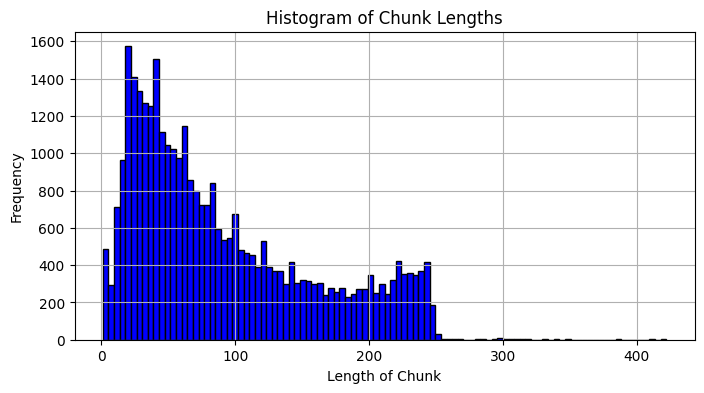

In [53]:
plt.figure(figsize=(8, 4))
plt.hist(df_Recursivechunked_articles['len_chunk'], bins=100, color='blue')
plt.title('Histogram of Chunk Lengths')
plt.xlabel('Length of Chunk')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

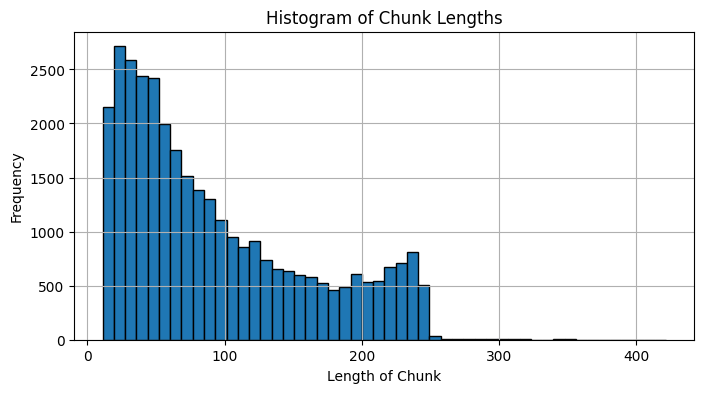

In [60]:
# remove the chunk that length is less than 10
df_Recursivechunked_articles = df_Recursivechunked_articles[df_Recursivechunked_articles['len_chunk'] > 10]

plt.figure(figsize=(8, 4))
plt.hist(df_Recursivechunked_articles['len_chunk'], bins=50,  edgecolor='black')
plt.title('Histogram of Chunk Lengths')
plt.xlabel('Length of Chunk')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()